# Price Setter and Follower

For approach used refer to the report and presentation

In [21]:
#importing the necessary packages
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import random

In [2]:
random.seed(10)
np.random.seed(42)
warnings.filterwarnings('ignore')

#### Pre-processing the data and Feature Engineering

In [3]:
data = pd.read_csv("PricingData.csv") #make sure the datafile in in the same directory
data.head()

,Seat Fare Type 1,Seat Fare Type 2,Bus,Service Date,RecordedAt
0,"900.00,800.00",NaN,d6fa79179fda2a77455794637f225962,15-07-2020 00:00,11-07-2020 16:28
1,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,15-07-2020 00:00,11-07-2020 19:17
2,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,15-07-2020 00:00,12-07-2020 09:02
3,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,15-07-2020 00:00,12-07-2020 10:05
4,"876.00,800.00,767.00,729.00",NaN,d6fa79179fda2a77455794637f225962,15-07-2020 00:00,13-07-2020 01:53


In [4]:
len(data["Bus"].unique())

117

In total we have 117 unique buses

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30649 entries, 0 to 30648
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Seat Fare Type 1  17785 non-null  object
 1   Seat Fare Type 2  12746 non-null  object
 2   Bus               30649 non-null  object
 3   Service Date      30649 non-null  object
 4   RecordedAt        30649 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [6]:
#rename the columns 
data=data.rename(columns={"Seat Fare Type 1":"f1","Seat Fare Type 2":"f2"})

In [7]:
#remove the entries with both seat fare types as NULL
data=data.dropna(subset=["f1","f2"], how='all')

In [9]:
#make a copy of data to revert back when needed
test=data.copy()


In [10]:
#convert the service date columns to pandas datetime format
test["Service Date"]=pd.to_datetime(test["Service Date"],format='%d-%m-%Y %H:%M')
test["RecordedAt"]=pd.to_datetime(test["RecordedAt"],format='%d-%m-%Y %H:%M')
print(test["Service Date"].dtype)
test.head()

datetime64[ns]


,f1,f2,Bus,Service Date,RecordedAt
0,"900.00,800.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00
1,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00
2,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00
3,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00
4,"876.00,800.00,767.00,729.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00


In [11]:
#creating a new column (variable)
test["timediff"]=test["Service Date"]-test["RecordedAt"]
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff
0,"900.00,800.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00
1,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00
2,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00
3,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00
4,"876.00,800.00,767.00,729.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00


In [12]:
#convert the timediff in minutes
days=test["timediff"].dt.days
hours=test["timediff"].dt.components["hours"]
mins=test["timediff"].dt.components["minutes"]
test["abstimediff"]=days*24*60+hours*60+mins
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff
0,"900.00,800.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00,4772
1,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00,4603
2,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00,3778
3,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00,3715
4,"876.00,800.00,767.00,729.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00,2767


In [13]:
test["abstimediff"].min()

-1339

Above -ve value indicates that the tickets have also been recorded after the service date. 

In [14]:
#reset the index (as some indexes were removed due to droping earlier) 
test=test.reset_index(drop=True)

In [16]:
#make the list of prices from the given string data
test["f1"]=test["f1"].astype(str)
test["f1_1"]=test.f1.str.split(',')

test["f2"]=test["f2"].astype(str)
test["f2_1"]=test.f2.str.split(',')
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff,f1_1,f2_1
0,"900.00,800.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00,4772,"[900.00, 800.00]",[nan]
1,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00,4603,"[910.00, 833.00, 795.00, 762.00]",[nan]
2,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00,3778,"[910.00, 833.00, 795.00, 762.00]",[nan]
3,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00,3715,"[910.00, 833.00, 795.00, 762.00]",[nan]
4,"876.00,800.00,767.00,729.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00,2767,"[876.00, 800.00, 767.00, 729.00]",[nan]


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30531 entries, 0 to 30648
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   f1            17785 non-null  object
 1   f2            12746 non-null  object
 2   Bus           30531 non-null  object
 3   Service Date  30531 non-null  object
 4   RecordedAt    30531 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


Clearly each bus has only one type of seat 

In [18]:
#convert the list to numeric data and creating columns for mean and std deviation
arr=[]
var=[]
for i in range(0,len(test["f1_1"])):
    if test["f1_1"][i][0]=='nan':
        arr.append(pd.to_numeric(test["f2_1"][i]).mean())
        var.append(pd.to_numeric(test["f2_1"][i]).std())
    #print(x)
    else:
        arr.append(pd.to_numeric(test["f1_1"][i]).mean())
        var.append(pd.to_numeric(test["f1_1"][i]).std())
test["meanfare"]=arr
test["devfare"]=var
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff,f1_1,f2_1,meanfare,devfare
0,"900.00,800.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00,4772,"[900.00, 800.00]",[nan],850.0,50.000000
1,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00,4603,"[910.00, 833.00, 795.00, 762.00]",[nan],825.0,55.131661
2,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00,3778,"[910.00, 833.00, 795.00, 762.00]",[nan],825.0,55.131661
3,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00,3715,"[910.00, 833.00, 795.00, 762.00]",[nan],825.0,55.131661
4,"876.00,800.00,767.00,729.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00,2767,"[876.00, 800.00, 767.00, 729.00]",[nan],793.0,54.106377


In [19]:
#Normalizing the features created with zero mean
test["abstimediff"]=(test["abstimediff"]-test["abstimediff"].mean())/test["abstimediff"].std()
test["meanfare"]=(test["meanfare"]-test["meanfare"].mean())/test["meanfare"].std()
test["devfare"]=(test["devfare"]-test["devfare"].mean())/test["devfare"].std()

In [20]:
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff,f1_1,f2_1,meanfare,devfare
0,"900.00,800.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00,0.273058,"[900.00, 800.00]",[nan],0.883657,1.333011
1,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00,0.253487,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730
2,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00,0.157946,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730
3,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00,0.150651,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730
4,"876.00,800.00,767.00,729.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00,0.040866,"[876.00, 800.00, 767.00, 729.00]",[nan],0.685737,1.507231


In [28]:
#create variable is_type1
test["is_type1"]=1
test.loc[test["f1"]=='nan',"is_type1"]=0
test.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff,f1_1,f2_1,meanfare,devfare,is_type1
0,"900.00,800.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 16:28:00,3 days 07:32:00,0.273058,"[900.00, 800.00]",[nan],0.883657,1.333011,1
1,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-11 19:17:00,3 days 04:43:00,0.253487,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730,1
2,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 09:02:00,2 days 14:58:00,0.157946,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730,1
3,"910.00,833.00,795.00,762.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-12 10:05:00,2 days 13:55:00,0.150651,"[910.00, 833.00, 795.00, 762.00]",[nan],0.796850,1.550730,1
4,"876.00,800.00,767.00,729.00",nan,d6fa79179fda2a77455794637f225962,2020-07-15,2020-07-13 01:53:00,1 days 22:07:00,0.040866,"[876.00, 800.00, 767.00, 729.00]",[nan],0.685737,1.507231,1


In [29]:
#save the current csv file (will be used for further processing)
test.to_csv("processed_data.csv")

In [37]:
data = pd.read_csv("processed_data.csv")
data.columns

Index(['Unnamed: 0', 'f1', 'f2', 'Bus', 'Service Date', 'RecordedAt',
       'timediff', 'abstimediff', 'f1_1', 'f2_1', 'meanfare', 'devfare',
       'is_type1'],
      dtype='object')

In [38]:
data=data.drop("Unnamed: 0",1)
data.head()

,f1,f2,Bus,Service Date,RecordedAt,timediff,abstimediff,f1_1,f2_1,meanfare,devfare,is_type1
0,"900.00,800.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15 00:00:00,2020-07-11 16:28:00,3 days 07:32:00,0.273058,"['900.00', '800.00']",['nan'],0.883657,1.333011,1
1,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15 00:00:00,2020-07-11 19:17:00,3 days 04:43:00,0.253487,"['910.00', '833.00', '795.00', '762.00']",['nan'],0.796850,1.550730,1
2,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15 00:00:00,2020-07-12 09:02:00,2 days 14:58:00,0.157946,"['910.00', '833.00', '795.00', '762.00']",['nan'],0.796850,1.550730,1
3,"910.00,833.00,795.00,762.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15 00:00:00,2020-07-12 10:05:00,2 days 13:55:00,0.150651,"['910.00', '833.00', '795.00', '762.00']",['nan'],0.796850,1.550730,1
4,"876.00,800.00,767.00,729.00",NaN,d6fa79179fda2a77455794637f225962,2020-07-15 00:00:00,2020-07-13 01:53:00,1 days 22:07:00,0.040866,"['876.00', '800.00', '767.00', '729.00']",['nan'],0.685737,1.507231,1


In [39]:
#create the feature is_weekend
data["Service Date"]=pd.to_datetime(data["Service Date"],format='%Y-%m-%d %H:%M')
data["is_weekend"]=0
data.loc[data["Service Date"].dt.dayofweek==5,"is_weekend"]=1
data.loc[data["Service Date"].dt.dayofweek==6,"is_weekend"]=1

In [40]:
#create a copy of data and remove the unnecessary columns
data_copy=data.copy()
data=data.drop(["f1","f2","Service Date","RecordedAt","timediff","f1_1","f2_1"],axis=1)
data.head()

,Bus,abstimediff,meanfare,devfare,is_type1,is_weekend
0,d6fa79179fda2a77455794637f225962,0.273058,0.883657,1.333011,1,0
1,d6fa79179fda2a77455794637f225962,0.253487,0.796850,1.550730,1,0
2,d6fa79179fda2a77455794637f225962,0.157946,0.796850,1.550730,1,0
3,d6fa79179fda2a77455794637f225962,0.150651,0.796850,1.550730,1,0
4,d6fa79179fda2a77455794637f225962,0.040866,0.685737,1.507231,1,0


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30531 entries, 0 to 30530
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bus          30531 non-null  object 
 1   abstimediff  30531 non-null  float64
 2   meanfare     30531 non-null  float64
 3   devfare      30531 non-null  float64
 4   is_type1     30531 non-null  int64  
 5   is_weekend   30531 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 1.4+ MB


In [42]:
#Grouping the data with unique bus id
data=data.groupby("Bus").agg(['mean','max'])
data.head()

abstimediff            meanfare            \
                                        mean       max      mean       max   
Bus                                                                          
060c6d5595f3d7cf53838b0b8c66673d   -0.072770  4.567848  0.428570  0.692681   
09bdda78c931e0758e2bda0f5e207502    0.684228  4.726966 -2.067787 -2.067787   
09d3a01cf347bce0b92631414af3fea8    0.126738  4.757075  0.552311  1.227413   
0a8db1499be670333833ded3c874c019   -0.173534  0.290892 -0.116796  0.102392   
0e10989e4726b5d68b0fb1d406335bc9    1.257942  4.728008 -2.067787 -2.067787   

                                   devfare           is_type1     is_weekend  \
                                      mean       max     mean max       mean   
Bus                                                                            
060c6d5595f3d7cf53838b0b8c66673d  0.179536  1.333011      0.0   0   0.255000   
09bdda78c931e0758e2bda0f5e207502 -0.788322 -0.788322      0.0   0   0.000000   
09d3a01cf347bce0b92631414af3fea8 -0.788322 -0.788322      0.0   0   0.703349   
0a8db1499be670333833ded3c874c019  0.182102  1.583400      1.0   1   0.000000   
0e10989e4726b5d68b0fb1d406335bc9 -0.788322 -0.788322      0.0   0   0.196429   

                                      
                                 max  
Bus                                   
060c6d5595f3d7cf53838b0b8c66673d   1  
09bdda78c931e0758e2bda0f5e207502   0  
09d3a01cf347bce0b92631414af3fea8   1  
0a8db1499be670333833ded3c874c019   0  
0e10989e4726b5d68b0fb1d406335bc9   1

In [43]:
data.columns

MultiIndex([('abstimediff', 'mean'),
            ('abstimediff',  'max'),
            (   'meanfare', 'mean'),
            (   'meanfare',  'max'),
            (    'devfare', 'mean'),
            (    'devfare',  'max'),
            (   'is_type1', 'mean'),
            (   'is_type1',  'max'),
            ( 'is_weekend', 'mean'),
            ( 'is_weekend',  'max')],
           )

In [44]:
data=data.drop([( 'is_weekend',  'max'),(   'is_type1',  'max'),],axis=1)
data=data.drop([(    'devfare',  'max'),(   'meanfare',  'max'),],axis=1)
data.columns = ['{}_{}'.format(x[0], x[1]) for x in data.columns]
data.head(10)

,abstimediff_mean,abstimediff_max,meanfare_mean,devfare_mean,is_type1_mean,is_weekend_mean
Bus,,,,,,
060c6d5595f3d7cf53838b0b8c66673d,-0.072770,4.567848,0.428570,0.179536,0.0,0.255000
09bdda78c931e0758e2bda0f5e207502,0.684228,4.726966,-2.067787,-0.788322,0.0,0.000000
09d3a01cf347bce0b92631414af3fea8,0.126738,4.757075,0.552311,-0.788322,0.0,0.703349
0a8db1499be670333833ded3c874c019,-0.173534,0.290892,-0.116796,0.182102,1.0,0.000000
0e10989e4726b5d68b0fb1d406335bc9,1.257942,4.728008,-2.067787,-0.788322,0.0,0.196429
1010397688bce9bb80e59ceb984d3477,-0.019811,4.575954,0.429022,-0.003171,1.0,0.218659
10598f3c00cb10feb6c5a369ea5d4331,0.217511,4.755107,0.573869,1.422110,1.0,0.219457
184d5bffbe383e9a7ddaa0b1fae8be87,0.777922,4.726850,-2.067787,-0.788322,0.0,0.000000
1d5363d20e0f4941bdf3084f131938b2,-0.106172,4.575375,0.141613,1.803931,1.0,0.000000


In [45]:
data_copy=data.copy()

In [46]:
#final feature matrix X
data=data.reset_index()
X=data.drop("Bus",axis=1)
X

,abstimediff_mean,abstimediff_max,meanfare_mean,devfare_mean,is_type1_mean,is_weekend_mean
0,-0.072770,4.567848,0.428570,0.179536,0.0,0.255000
1,0.684228,4.726966,-2.067787,-0.788322,0.0,0.000000
2,0.126738,4.757075,0.552311,-0.788322,0.0,0.703349
3,-0.173534,0.290892,-0.116796,0.182102,1.0,0.000000
4,1.257942,4.728008,-2.067787,-0.788322,0.0,0.196429
...,...,...,...,...,...,...
112,4.192659,4.726155,-2.067787,-0.788322,0.0,0.000000
113,-0.255729,-0.052126,0.015585,0.969690,1.0,0.000000
114,-0.058884,1.722720,-2.067787,-0.788322,0.0,0.000000
115,-0.081759,5.909811,0.381561,0.078340,1.0,0.000000


### Modeling and visualization

In [47]:
#create the final features sheet to be used ahead
X.to_csv("features.csv")

In [48]:
data = pd.read_csv("features.csv")
data.columns

Index(['Unnamed: 0', 'abstimediff_mean', 'abstimediff_max', 'meanfare_mean',
       'devfare_mean', 'is_type1_mean', 'is_weekend_mean'],
      dtype='object')

In [50]:
data=data.reset_index()
X=data.drop(["index","Unnamed: 0"],axis=1)
X.head()

,abstimediff_mean,abstimediff_max,meanfare_mean,devfare_mean,is_type1_mean,is_weekend_mean
0,-0.072770,4.567848,0.428570,0.179536,0.0,0.255000
1,0.684228,4.726966,-2.067787,-0.788322,0.0,0.000000
2,0.126738,4.757075,0.552311,-0.788322,0.0,0.703349
3,-0.173534,0.290892,-0.116796,0.182102,1.0,0.000000
4,1.257942,4.728008,-2.067787,-0.788322,0.0,0.196429


In [51]:
#using PCA for dimentionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.6661764  0.24602771]
Cumulative variance explained by 2 principal components: 91.22%


#### Using Silhoutte score to get the number of clusters

In [52]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

Parameter: {'n_clusters': 2} Score 0.49663501954969574
Parameter: {'n_clusters': 3} Score 0.6009204551189771
Parameter: {'n_clusters': 4} Score 0.6492596053344598
Parameter: {'n_clusters': 5} Score 0.6756986781416792
Parameter: {'n_clusters': 10} Score 0.6210491810750283
Parameter: {'n_clusters': 15} Score 0.6545859098859671
Parameter: {'n_clusters': 20} Score 0.6108495860836421
Parameter: {'n_clusters': 25} Score 0.6132871387610053
Parameter: {'n_clusters': 30} Score 0.5948421120063753
Parameter: {'n_clusters': 35} Score 0.4909950016414721
Parameter: {'n_clusters': 40} Score 0.47727543043383475


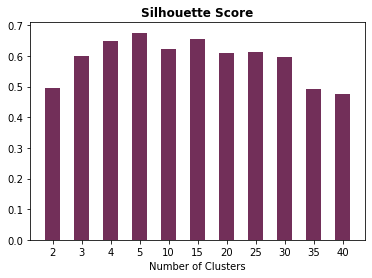

In [53]:
# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(pca_result)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(pca_result, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Parameter: {'n_clusters': 5} Score 0.6756986781416792
Parameter: {'n_clusters': 6} Score 0.6954620556214197
Parameter: {'n_clusters': 7} Score 0.6782877106589658
Parameter: {'n_clusters': 8} Score 0.6471606083262152
Parameter: {'n_clusters': 9} Score 0.6145273642430323
Parameter: {'n_clusters': 10} Score 0.620390648485376


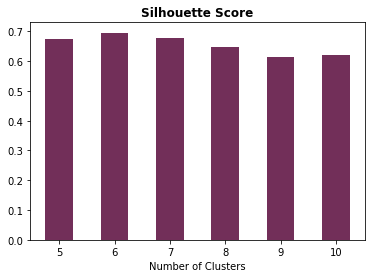

In [55]:
#again using the analysis between 5-10 clusters
# candidate values for our number of cluster
parameters = [5, 6, 7, 8, 9, 10]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(pca_result)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(pca_result, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

From above the optimal number of clusters to be used is 6

In [56]:
#creating our base model (stage I clustering)
model1 = KMeans(n_clusters=6) 
model1.fit(pca_result)

KMeans(n_clusters=6)

In [57]:
#function defination for visualizing the clusters on the PCA plane
def visualizing_results(pca_result, label, centroids_pca):
    """ Visualizing the clusters
    :param pca_result: PCA applied data
    :param label: K Means labels
    :param centroids_pca: PCA format K Means centroids
    """
    # ------------------ Using Matplotlib for plotting-----------------------
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    plt.scatter(x, y, c=label, alpha=0.5, s= 200)  # plot different colors per cluster
    plt.title('Bus Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

    plt.show()

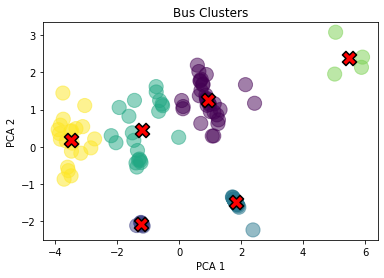

In [58]:
visualizing_results(pca_result, model1.labels_, model1.cluster_centers_)

In [59]:
model1.labels_

array([0, 2, 0, 5, 2, 0, 0, 2, 0, 2, 2, 2, 2, 3, 5, 3, 2, 0, 5, 5, 2, 5,
       5, 3, 3, 3, 2, 1, 2, 3, 2, 0, 1, 4, 3, 2, 0, 0, 3, 2, 0, 2, 0, 5,
       2, 4, 1, 3, 2, 0, 3, 0, 3, 0, 3, 5, 3, 5, 0, 0, 5, 2, 4, 1, 0, 1,
       5, 0, 5, 5, 3, 0, 5, 2, 2, 1, 5, 2, 3, 0, 2, 2, 0, 5, 5, 0, 4, 3,
       0, 2, 0, 0, 0, 3, 3, 1, 3, 0, 2, 0, 0, 5, 2, 0, 3, 3, 2, 5, 2, 5,
       2, 0, 2, 5, 1, 0, 2])

In [60]:
model1.cluster_centers_

array([[ 0.92277957,  1.2536837 ],
       [-1.22815002, -2.08274264],
       [ 1.83139844, -1.49921987],
       [-1.20298777,  0.44465717],
       [ 5.46811155,  2.39841336],
       [-3.48032384,  0.19468687]])

In [64]:
data_copy = data_copy.reset_index()
data_copy

,Bus,abstimediff_mean,abstimediff_max,meanfare_mean,devfare_mean,is_type1_mean,is_weekend_mean
0,060c6d5595f3d7cf53838b0b8c66673d,-0.072770,4.567848,0.428570,0.179536,0.0,0.255000
1,09bdda78c931e0758e2bda0f5e207502,0.684228,4.726966,-2.067787,-0.788322,0.0,0.000000
2,09d3a01cf347bce0b92631414af3fea8,0.126738,4.757075,0.552311,-0.788322,0.0,0.703349
3,0a8db1499be670333833ded3c874c019,-0.173534,0.290892,-0.116796,0.182102,1.0,0.000000
4,0e10989e4726b5d68b0fb1d406335bc9,1.257942,4.728008,-2.067787,-0.788322,0.0,0.196429
...,...,...,...,...,...,...,...
112,f9e27e929e3d6d33dc09bf6d7ceb97bc,4.192659,4.726155,-2.067787,-0.788322,0.0,0.000000
113,fa311021504691f83fa777072f491f0b,-0.255729,-0.052126,0.015585,0.969690,1.0,0.000000
114,fa76862522249456f475c02b790da604,-0.058884,1.722720,-2.067787,-0.788322,0.0,0.000000
115,fd6cb8a34210b39ef547b94741ffa83b,-0.081759,5.909811,0.381561,0.078340,1.0,0.000000


In [66]:
#concatinating the bus number in file
bus = data_copy["Bus"]
bus=pd.DataFrame(bus)
y=pd.concat((bus,pd.DataFrame(pca_result),pd.DataFrame(model1.labels_,columns = ["Cluster"])),axis=1)
y = y.rename(columns = {0:"pca1",1:"pca2"})
y

,Bus,pca1,pca2,Cluster
0,060c6d5595f3d7cf53838b0b8c66673d,0.903060,1.115174,0
1,09bdda78c931e0758e2bda0f5e207502,1.767321,-1.409429,2
2,09d3a01cf347bce0b92631414af3fea8,1.218653,0.858405,0
3,0a8db1499be670333833ded3c874c019,-3.173383,-0.171820,5
4,0e10989e4726b5d68b0fb1d406335bc9,1.867078,-1.546112,2
...,...,...,...,...
112,f9e27e929e3d6d33dc09bf6d7ceb97bc,2.383130,-2.237309,2
113,fa311021504691f83fa777072f491f0b,-3.642734,0.154635,5
114,fa76862522249456f475c02b790da604,-1.236524,-2.035362,1
115,fd6cb8a34210b39ef547b94741ffa83b,2.140431,1.672719,0


### Stage II clustering 

In [67]:
#create a seperate list for each cluster
cluster=[]
for i in range(6):
    cluster.append(y[y["Cluster"]==i])
cluster[2]

,Bus,pca1,pca2,Cluster
1,09bdda78c931e0758e2bda0f5e207502,1.767321,-1.409429,2
4,0e10989e4726b5d68b0fb1d406335bc9,1.867078,-1.546112,2
7,184d5bffbe383e9a7ddaa0b1fae8be87,1.783676,-1.431563,2
9,1df3d998c99605d1d1cd99a1b2f660a4,1.927493,-1.627411,2
10,1e8f943f51641d72889455e26d49dec7,1.839501,-1.509694,2
11,1ea201abd079f8d7129870e1fa13f3cf,1.730862,-1.360920,2
12,1f159e801b6c0470d774210faa11803e,1.822634,-1.483678,2
16,23400e84ea8d9f642252d1c343d26464,1.815999,-1.477812,2
20,25a091322a8c1d5629cc2a4881757656,1.868528,-1.549005,2
26,3296bff791975aa0e5cccf7602875e82,1.819971,-1.484874,2


In [81]:
cluster[5]

,Bus,pca1,pca2,Cluster
3,0a8db1499be670333833ded3c874c019,-3.173383,-0.171820,5
14,225554f4707e5122d97d5fb642b10af3,-3.476255,-0.117402,5
18,23ca24cf2af71cfd6c438386ffb7d33e,-3.497916,0.413359,5
19,241f07f1fafbd5405c0139ae4a148a74,-3.489222,-0.781299,5
21,28af5b39ca85472e76714235b77a08c6,-3.741128,0.742664,5
22,28fd7bdc6b80666877c3e9dd41e0ae5a,-3.833913,0.582960,5
43,57a24b73e1abc5627cbdfbf487031eb0,-2.727481,0.210992,5
55,6cd4a532abcdc965836201b59915eb99,-3.904793,0.462067,5
57,6ebe14c775a983e43b07c55e6b71d77d,-3.752087,1.446717,5
60,74cc09e5cb64134800650f0c21f94942,-3.578119,-0.642378,5


Now we will do the Silhoutte Analysis for each sub-cluster

Parameter: {'n_clusters': 2} Score 0.39269149385361446
Parameter: {'n_clusters': 3} Score 0.43973949420333674
Parameter: {'n_clusters': 4} Score 0.528644307667679
Parameter: {'n_clusters': 5} Score 0.5107815919308538
Parameter: {'n_clusters': 6} Score 0.5207739940613496
Parameter: {'n_clusters': 7} Score 0.5028126564088782
Parameter: {'n_clusters': 8} Score 0.4581546956096088
Parameter: {'n_clusters': 9} Score 0.47233330190500444
Parameter: {'n_clusters': 10} Score 0.43803430491375583


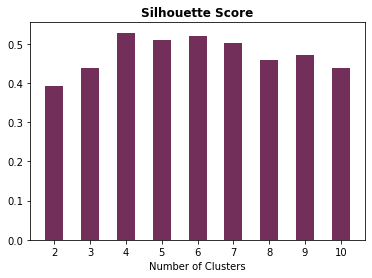

In [86]:
X=cluster[0][["pca1","pca2"]].to_numpy()
parameters = [2,3,4,5,6,7,8,9,10]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 4

Parameter: {'n_clusters': 2} Score 0.5917493296220009
Parameter: {'n_clusters': 3} Score 0.5368616125186136
Parameter: {'n_clusters': 4} Score 0.40276965917035085
Parameter: {'n_clusters': 5} Score 0.3105167833619208
Parameter: {'n_clusters': 6} Score 0.24538946802936
Parameter: {'n_clusters': 7} Score 0.10783781242171403


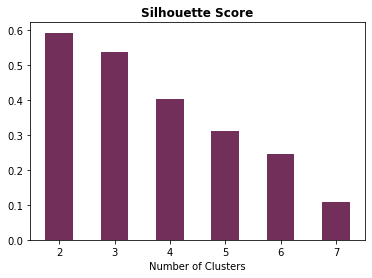

In [88]:
X=cluster[1][["pca1","pca2"]].to_numpy()
parameters = [2,3,4,5,6,7]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 2

Parameter: {'n_clusters': 2} Score 0.8659281696186677
Parameter: {'n_clusters': 3} Score 0.5508531824667756
Parameter: {'n_clusters': 4} Score 0.5435818139267536
Parameter: {'n_clusters': 5} Score 0.6114584123427143
Parameter: {'n_clusters': 6} Score 0.6253837807353446
Parameter: {'n_clusters': 7} Score 0.6408734481505215
Parameter: {'n_clusters': 8} Score 0.6638527475052289
Parameter: {'n_clusters': 9} Score 0.6392626789857232
Parameter: {'n_clusters': 10} Score 0.6336396059022593


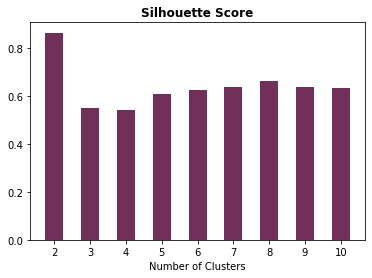

In [89]:
X=cluster[2][["pca1","pca2"]].to_numpy()
parameters = [2,3,4,5,6,7,8,9,10]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 2

Parameter: {'n_clusters': 2} Score 0.532758101915912
Parameter: {'n_clusters': 3} Score 0.5426608225919292
Parameter: {'n_clusters': 4} Score 0.53421372479987
Parameter: {'n_clusters': 5} Score 0.570761343163791
Parameter: {'n_clusters': 6} Score 0.6007654740837395
Parameter: {'n_clusters': 7} Score 0.5834602105907398
Parameter: {'n_clusters': 8} Score 0.5519196256169283
Parameter: {'n_clusters': 9} Score 0.46983024151343966
Parameter: {'n_clusters': 10} Score 0.448660142408348


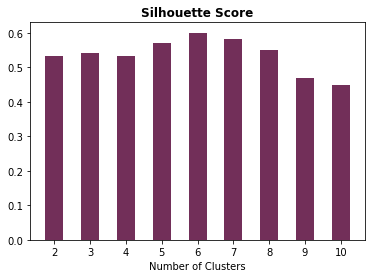

In [90]:
X=cluster[3][["pca1","pca2"]].to_numpy()
parameters = [2,3,4,5,6,7,8,9,10]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 6

Parameter: {'n_clusters': 2} Score 0.2783100297719497
Parameter: {'n_clusters': 3} Score 0.35290633997167165


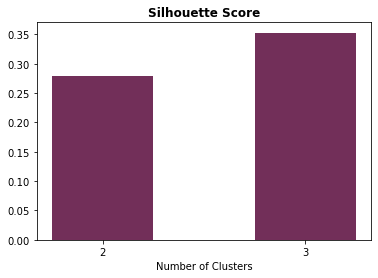

In [94]:
X=cluster[4][["pca1","pca2"]].to_numpy()
parameters = [2,3]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 3

Parameter: {'n_clusters': 2} Score 0.40829176975287124
Parameter: {'n_clusters': 3} Score 0.37295373895529893
Parameter: {'n_clusters': 4} Score 0.4570799511050271
Parameter: {'n_clusters': 5} Score 0.4131608997508894
Parameter: {'n_clusters': 6} Score 0.436688382921006
Parameter: {'n_clusters': 7} Score 0.44270716310382785
Parameter: {'n_clusters': 8} Score 0.41690406265745716
Parameter: {'n_clusters': 9} Score 0.3818735757218974
Parameter: {'n_clusters': 10} Score 0.36802237815679795


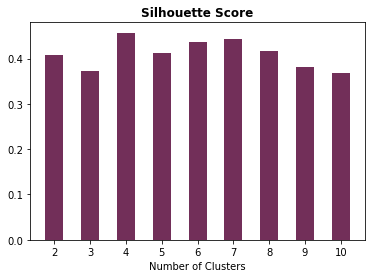

In [97]:
X=cluster[5][["pca1","pca2"]].to_numpy()
parameters = [2,3,4,5,6,7,8,9,10]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

Optimal number of clusters = 4

In [98]:
#creating seperate models for each primary cluster using optimal number from above analysis
X0=cluster[0][["pca1","pca2"]].to_numpy()
m0 = KMeans(n_clusters=4) 
m0.fit(X0)
X1=cluster[1][["pca1","pca2"]].to_numpy()
m1 = KMeans(n_clusters=2) 
m1.fit(X1)
X2=cluster[2][["pca1","pca2"]].to_numpy()
m2 = KMeans(n_clusters=2) 
m2.fit(X2)
X3=cluster[3][["pca1","pca2"]].to_numpy()
m3 = KMeans(n_clusters=6) 
m3.fit(X3)
X4=cluster[4][["pca1","pca2"]].to_numpy()
m4 = KMeans(n_clusters=3) 
m4.fit(X4)
X5=cluster[5][["pca1","pca2"]].to_numpy()
m5 = KMeans(n_clusters=4) 
m5.fit(X5)

KMeans(n_clusters=4)

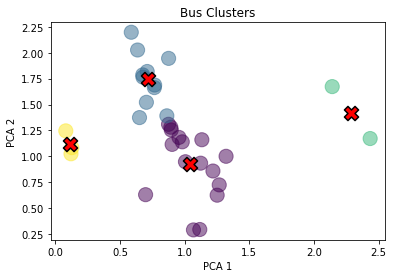

In [99]:
visualizing_results(X0, m0.labels_, m0.cluster_centers_)

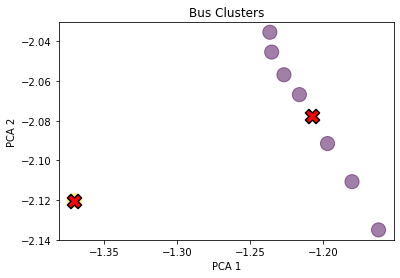

In [100]:
visualizing_results(X1, m1.labels_, m1.cluster_centers_)

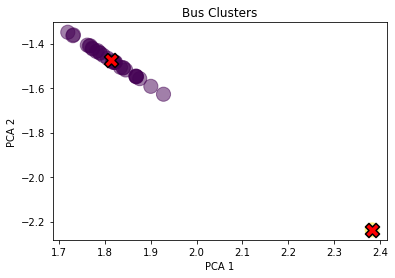

In [101]:
visualizing_results(X2, m2.labels_, m2.cluster_centers_)

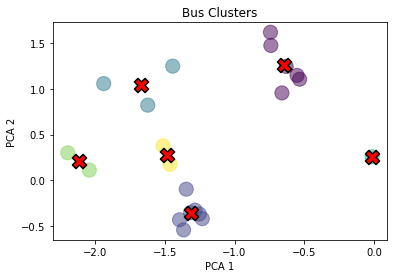

In [102]:
visualizing_results(X3, m3.labels_, m3.cluster_centers_)

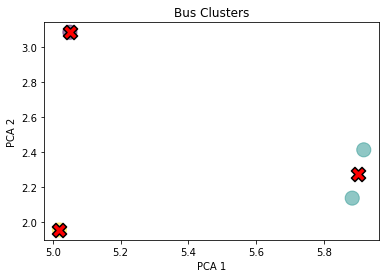

In [103]:
visualizing_results(X4, m4.labels_, m4.cluster_centers_)

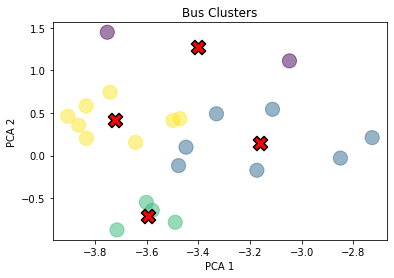

In [104]:
visualizing_results(X5, m5.labels_, m5.cluster_centers_)

In [105]:
#fuctions to be used later to generate confidence score
def dist_from_own_centre(pca_result,centroids,labels):
    arr=np.zeros(len(labels))
    for i in range(len(labels)):
        arr[i]=1/((np.sum((pca_result[i] - centroids[labels[i]])**2))**0.5+1e-8)
    return arr
def dist_from_other_centre(pca_result,centroids,labels):
    arr=np.zeros(len(labels))
    for i in range(len(labels)):
        for j in range(len(centroids)):
            arr[i] += 1/((np.sum((pca_result[i] - centroids[j])**2))**0.5+1e-8)
    return arr

In [107]:
#the leader follower function takes as input a particular label of the secondary cluster and assign the leader follower accordingly
#Probability will be calculated ahead
def leader_follower(cluster):  #only bus and prob for a particular cluster (sorted)
    cluster["Follows"] = ""
    cluster["Confidence Score 1"] = ""
    cluster["Is followed by"] = ""
    cluster["Confidence Score 2"] = ""
    maxprob = cluster["Probability"][0]
    leader = cluster["Bus"][0]
    #confidence_score_1 = cluster["Probability"][0]
    cluster["Follows"][0] = "Independent"
    cluster["Confidence Score 1"][0] = 1-cluster["Probability"][0]
    #confidence_score_2 = 
    if len(cluster)==1:
        return cluster
    follower = cluster["Bus"][1]
    for i in range(1,len(cluster)):
        cluster["Follows"][i] = leader
        cluster["Confidence Score 1"][i] = cluster["Probability"][i]/cluster["Probability"][i-1]
        leader = cluster["Bus"][i]
        #confidence_score_1 = cluster["Probability"][i]
    for i in range(0,len(cluster)-1):
        cluster["Is followed by"][i] = follower
        follower = cluster["Bus"][i+1]
        cluster["Confidence Score 2"][i] = cluster["Probability"][i+1]/cluster["Probability"][i]
    #cluster["Is followed by"][len(cluster)-1] = ""
    #cluster["Confidence Score 2"][i]
            
    return cluster

Below is the process for each cluster

In [108]:
prob0 = dist_from_own_centre(X0,m0.cluster_centers_,m0.labels_)/dist_from_other_centre(X0,m0.cluster_centers_,m0.labels_)
prob0

array([0.54422476, 0.66703219, 0.36346547, 0.60871598, 0.88133028,
       0.43436918, 0.39148772, 0.80333411, 0.40258839, 0.74075712,
       0.50465066, 0.85361164, 0.90671206, 0.56309638, 0.54970479,
       0.53768179, 0.40036116, 0.58854173, 0.81319006, 0.81831912,
       0.6705883 , 0.82735668, 0.57413055, 0.44364783, 0.56413175,
       0.49922546, 0.77856174, 0.43572853, 0.87767983, 0.55306548,
       0.41362704, 0.64082722])

In [109]:
cluster[0]["Probability"] = prob0
cluster[0]["labels"] = m0.labels_
cluster[0]

,Bus,pca1,pca2,Cluster,Probability,labels
0,060c6d5595f3d7cf53838b0b8c66673d,0.903060,1.115174,0,0.544225,0
2,09d3a01cf347bce0b92631414af3fea8,1.218653,0.858405,0,0.667032,0
5,1010397688bce9bb80e59ceb984d3477,0.875431,1.309132,0,0.363465,0
6,10598f3c00cb10feb6c5a369ea5d4331,0.875989,1.945014,0,0.608716,1
8,1d5363d20e0f4941bdf3084f131938b2,0.677472,1.764113,0,0.881330,1
17,23c7bd7bcab9a19b7da7cae4e3d4659a,1.068004,0.290068,0,0.434369,0
31,3f16e520e1e84f8b9a72b63cbc4fb598,0.893255,1.280787,0,0.391488,0
36,4f442421f3255cd732698b660003791e,0.121593,1.024545,0,0.803334,3
37,52725e18d5c8af87b097a33ca2282a10,0.651006,1.373825,0,0.402588,1
40,5580f995d6f4d3bcceca7e2db6c77bf7,0.081376,1.245701,0,0.740757,3


In [110]:
output = cluster[0][cluster[0]["labels"]==1]
output = output.sort_values("Probability",ascending = False)
output = output.reset_index()
result = leader_follower(output)
result

,index,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
0,8,1d5363d20e0f4941bdf3084f131938b2,0.677472,1.764113,0,0.881330,1,Independent,0.11867,626d457856a4635087133cf957abae2b,0.968549
1,49,626d457856a4635087133cf957abae2b,0.676191,1.785861,0,0.853612,1,1d5363d20e0f4941bdf3084f131938b2,0.968549,626d457856a4635087133cf957abae2b,0.969243
2,85,a85170e65d1c03e1ea78595c0d8deb80,0.710533,1.818517,0,0.827357,1,626d457856a4635087133cf957abae2b,0.969243,a85170e65d1c03e1ea78595c0d8deb80,0.989077
3,79,a0243f8c4129f3a468ede17e832a7a9a,0.768002,1.687882,0,0.818319,1,a85170e65d1c03e1ea78595c0d8deb80,0.989077,a0243f8c4129f3a468ede17e832a7a9a,0.951416
4,97,c3001e2a3fcf58a3f9881a6635d8765a,0.765774,1.663224,0,0.778562,1,a0243f8c4129f3a468ede17e832a7a9a,0.951416,c3001e2a3fcf58a3f9881a6635d8765a,0.781847
5,6,10598f3c00cb10feb6c5a369ea5d4331,0.875989,1.945014,0,0.608716,1,c3001e2a3fcf58a3f9881a6635d8765a,0.781847,10598f3c00cb10feb6c5a369ea5d4331,0.966858
6,67,8239a4d7ab3b3de7711c6cb7748229bf,0.636255,2.025770,0,0.588542,1,10598f3c00cb10feb6c5a369ea5d4331,0.966858,8239a4d7ab3b3de7711c6cb7748229bf,0.958525
7,91,b8d1710db82f66126ca3f540f2ad2f08,0.704265,1.521184,0,0.564132,1,8239a4d7ab3b3de7711c6cb7748229bf,0.958525,b8d1710db82f66126ca3f540f2ad2f08,0.884945
8,92,bae2b9f85a7c3e8eaea1a12ac8be7af2,0.587388,2.197098,0,0.499225,1,b8d1710db82f66126ca3f540f2ad2f08,0.884945,bae2b9f85a7c3e8eaea1a12ac8be7af2,0.806426
9,37,52725e18d5c8af87b097a33ca2282a10,0.651006,1.373825,0,0.402588,1,bae2b9f85a7c3e8eaea1a12ac8be7af2,0.806426,52725e18d5c8af87b097a33ca2282a10,0.994468


In [113]:
output=[]
result=[]
for i in range(4):
    output.append(cluster[0][cluster[0]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))

In [114]:
Y0 = result[0]
for i in range(1,len(result)):
    Y0 = pd.concat((Y0,result[i]))
Y0=Y0.set_index("index")
Y0

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
100,ca5a5dcf590a304de20107f2f119fe4d,1.006168,0.947908,0,0.877680,0,Independent,0.12232,9656d6395d1f3a4497d0871a03366078,0.926522
71,9656d6395d1f3a4497d0871a03366078,1.123356,0.933989,0,0.813190,0,ca5a5dcf590a304de20107f2f119fe4d,0.926522,9656d6395d1f3a4497d0871a03366078,0.820266
2,09d3a01cf347bce0b92631414af3fea8,1.218653,0.858405,0,0.667032,0,9656d6395d1f3a4497d0871a03366078,0.820266,09d3a01cf347bce0b92631414af3fea8,0.860724
88,b38712db6ce31a420650d8e701799aee,1.267133,0.724411,0,0.574131,0,09d3a01cf347bce0b92631414af3fea8,0.860724,b38712db6ce31a420650d8e701799aee,0.980781
53,6b4c5b251baf9846a4c4273693154363,0.981383,1.139823,0,0.563096,0,b38712db6ce31a420650d8e701799aee,0.980781,6b4c5b251baf9846a4c4273693154363,0.982186
103,d1854bef9a416d20150912c61a1fb9e1,1.320052,1.000323,0,0.553065,0,6b4c5b251baf9846a4c4273693154363,0.982186,d1854bef9a416d20150912c61a1fb9e1,0.993924
58,74017231b804c80d3f1fa28be2fe0ffa,1.132906,1.159986,0,0.549705,0,d1854bef9a416d20150912c61a1fb9e1,0.993924,74017231b804c80d3f1fa28be2fe0ffa,0.990031
0,060c6d5595f3d7cf53838b0b8c66673d,0.903060,1.115174,0,0.544225,0,74017231b804c80d3f1fa28be2fe0ffa,0.990031,060c6d5595f3d7cf53838b0b8c66673d,0.987977
59,74b23405506957f6b6ddb29c0574260b,1.251206,0.625068,0,0.537682,0,060c6d5595f3d7cf53838b0b8c66673d,0.987977,74b23405506957f6b6ddb29c0574260b,0.938568


In [115]:
prob1 = dist_from_own_centre(X1,m1.cluster_centers_,m1.labels_)/dist_from_other_centre(X1,m1.cluster_centers_,m1.labels_)
cluster[1]["Probability"] = prob1
cluster[1]["labels"] = m1.labels_

output=[]
result=[]
for i in range(2):
    output.append(cluster[1][cluster[1]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))
    
Y1 = result[0]
for i in range(1,len(result)):
    Y1 = pd.concat((Y1,result[i]))
    
Y1=Y1.set_index("index")
Y1

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
46,5fdbc1be84c32354f4f0ce12bc892d9b,-1.216365,-2.066824,1,0.923120,0,Independent,0.07688,37109b9c632f84d35aa6127e70483fe1,0.983938
27,37109b9c632f84d35aa6127e70483fe1,-1.197119,-2.091513,1,0.908293,0,5fdbc1be84c32354f4f0ce12bc892d9b,0.983938,37109b9c632f84d35aa6127e70483fe1,0.933918
75,9c7fe90a2be7a64e7aa8517d21243a4d,-1.226910,-2.056810,1,0.848270,0,37109b9c632f84d35aa6127e70483fe1,0.933918,9c7fe90a2be7a64e7aa8517d21243a4d,0.960653
95,be5bded2953a916d334eb492b0c37296,-1.180366,-2.110746,1,0.814893,0,9c7fe90a2be7a64e7aa8517d21243a4d,0.960653,be5bded2953a916d334eb492b0c37296,0.963812
32,45f6409fc90e6a3c03b27ba3560fc90a,-1.235308,-2.045357,1,0.785404,0,be5bded2953a916d334eb492b0c37296,0.963812,45f6409fc90e6a3c03b27ba3560fc90a,0.963816
114,fa76862522249456f475c02b790da604,-1.236524,-2.035362,1,0.756984,0,45f6409fc90e6a3c03b27ba3560fc90a,0.963816,fa76862522249456f475c02b790da604,0.976794
65,819406683415c007cf6ec938e6eaec3a,-1.162240,-2.135077,1,0.739417,0,fa76862522249456f475c02b790da604,0.976794,,
63,799cf5e9d9ab688d72e17d530ed36bef,-1.370369,-2.120254,1,1.000000,1,Independent,0.0,,


In [116]:
prob2 = dist_from_own_centre(X2,m2.cluster_centers_,m2.labels_)/dist_from_other_centre(X2,m2.cluster_centers_,m2.labels_)
cluster[2]["Probability"] = prob2
cluster[2]["labels"] = m2.labels_

output=[]
result=[]
for i in range(2):
    output.append(cluster[2][cluster[2]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))
    
Y2 = result[0]
for i in range(1,len(result)):
    Y2 = pd.concat((Y2,result[i]))
    
Y2=Y2.set_index("index")
Y2

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
16,23400e84ea8d9f642252d1c343d26464,1.815999,-1.477812,2,0.995404,0,Independent,0.004596,cfa18a60741f6e93df4f7ea15cb0e30b,0.993539
102,cfa18a60741f6e93df4f7ea15cb0e30b,1.817471,-1.484125,2,0.988972,0,23400e84ea8d9f642252d1c343d26464,0.993539,cfa18a60741f6e93df4f7ea15cb0e30b,0.998748
48,618277d91c983594fa09598cbaa94c4e,1.805290,-1.465461,2,0.987734,0,cfa18a60741f6e93df4f7ea15cb0e30b,0.998748,618277d91c983594fa09598cbaa94c4e,0.999275
108,f113e02b1204e93df04ca357afc6b103,1.821162,-1.483909,2,0.987018,0,618277d91c983594fa09598cbaa94c4e,0.999275,f113e02b1204e93df04ca357afc6b103,0.999962
26,3296bff791975aa0e5cccf7602875e82,1.819971,-1.484874,2,0.986980,0,f113e02b1204e93df04ca357afc6b103,0.999962,3296bff791975aa0e5cccf7602875e82,0.999127
12,1f159e801b6c0470d774210faa11803e,1.822634,-1.483678,2,0.986119,0,3296bff791975aa0e5cccf7602875e82,0.999127,1f159e801b6c0470d774210faa11803e,0.986453
80,a2f5b7949d62049bcd0b4682bd9173eb,1.795990,-1.453099,2,0.972759,0,1f159e801b6c0470d774210faa11803e,0.986453,a2f5b7949d62049bcd0b4682bd9173eb,0.989066
116,fde3cb1975a46ee670de4ee663909d52,1.789453,-1.443504,2,0.962123,0,a2f5b7949d62049bcd0b4682bd9173eb,0.989066,fde3cb1975a46ee670de4ee663909d52,0.998217
41,55d025d1d77431effef6d6680a2aea33,1.833475,-1.506283,2,0.960408,0,fde3cb1975a46ee670de4ee663909d52,0.998217,55d025d1d77431effef6d6680a2aea33,0.999094


In [117]:
prob3 = dist_from_own_centre(X3,m3.cluster_centers_,m3.labels_)/dist_from_other_centre(X3,m3.cluster_centers_,m3.labels_)
cluster[3]["Probability"] = prob3
cluster[3]["labels"] = m3.labels_

output=[]
result=[]
for i in range(6):
    output.append(cluster[3][cluster[3]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))
    
Y3 = result[0]
for i in range(1,len(result)):
    Y3 = pd.concat((Y3,result[i]))
    
Y3=Y3.set_index("index")
Y3

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
70,94e6adf5189531e3a52686bb17c2b2ad,-0.630595,1.246086,3,0.936721,0,Independent,0.063279,d6fa79179fda2a77455794637f225962,0.693278
105,d6fa79179fda2a77455794637f225962,-0.552871,1.148318,3,0.649408,0,94e6adf5189531e3a52686bb17c2b2ad,0.693278,d6fa79179fda2a77455794637f225962,0.896318
23,29b77a9e58d23bf43daa780eb8b7db65,-0.534390,1.106340,3,0.582077,0,d6fa79179fda2a77455794637f225962,0.896318,29b77a9e58d23bf43daa780eb8b7db65,0.944952
24,3014ebaddbddfbfc27bf6d8958851aa5,-0.739974,1.476203,3,0.550035,0,29b77a9e58d23bf43daa780eb8b7db65,0.944952,3014ebaddbddfbfc27bf6d8958851aa5,0.825222
29,3b9b3497d23b8212272f1b4c1f70bbfa,-0.742857,1.620894,3,0.453901,0,3014ebaddbddfbfc27bf6d8958851aa5,0.825222,3b9b3497d23b8212272f1b4c1f70bbfa,0.959901
93,bb34a6d5a6c5e806c2bdc7afc63e4397,-0.660737,0.955729,3,0.435700,0,3b9b3497d23b8212272f1b4c1f70bbfa,0.959901,,
54,6b60fb99e5de6ac90be3fb256c7edd33,-1.313872,-0.356232,3,0.959126,1,Independent,0.040874,3100ec449829e65ed2da9f7af62ef03d,0.857741
25,3100ec449829e65ed2da9f7af62ef03d,-1.282613,-0.328628,3,0.822681,1,6b60fb99e5de6ac90be3fb256c7edd33,0.857741,3100ec449829e65ed2da9f7af62ef03d,0.962944
87,b2dcc123101698aa3c6254f0e985921f,-1.252416,-0.371163,3,0.792196,1,3100ec449829e65ed2da9f7af62ef03d,0.962944,b2dcc123101698aa3c6254f0e985921f,0.890747


In [118]:
prob4 = dist_from_own_centre(X4,m4.cluster_centers_,m4.labels_)/dist_from_other_centre(X4,m4.cluster_centers_,m4.labels_)
cluster[4]["Probability"] = prob4
cluster[4]["labels"] = m4.labels_

output=[]
result=[]
for i in range(3):
    output.append(cluster[4][cluster[4]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))
    
Y4 = result[0]
for i in range(1,len(result)):
    Y4 = pd.concat((Y4,result[i]))
    
Y4=Y4.set_index("index")
Y4

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
62,78690969ed345320991aba0cd59e0733,5.050389,3.083228,4,1.000000,0,Independent,0.0,,
45,5efeca02cbcf91c6230fd894cfae0b1f,5.918368,2.413787,4,0.791277,1,Independent,0.208723,49a138fe484117e03704bcd345a83d32,0.997681
33,49a138fe484117e03704bcd345a83d32,5.884233,2.138874,4,0.789442,1,5efeca02cbcf91c6230fd894cfae0b1f,0.997681,,
86,ab479dab4a9e6bc3eaefe77a09f027ed,5.019456,1.957764,4,1.000000,2,Independent,0.0,,


In [119]:
prob5 = dist_from_own_centre(X5,m5.cluster_centers_,m5.labels_)/dist_from_other_centre(X5,m5.cluster_centers_,m5.labels_)
cluster[5]["Probability"] = prob5
cluster[5]["labels"] = m5.labels_

output=[]
result=[]
for i in range(4):
    output.append(cluster[5][cluster[5]["labels"]==i])
    output[i] = output[i].sort_values("Probability",ascending = False)
    output[i] = output[i].reset_index()
    result.append(leader_follower(output[i]))
    
Y5 = result[0]
for i in range(1,len(result)):
    Y5 = pd.concat((Y5,result[i]))
    
Y5=Y5.set_index("index")
Y5

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
57,6ebe14c775a983e43b07c55e6b71d77d,-3.752087,1.446717,5,0.545501,0,Independent,0.454499,a70bfd3145f3c601b7b8371845be6e57,0.911708
84,a70bfd3145f3c601b7b8371845be6e57,-3.047363,1.110792,5,0.497338,0,6ebe14c775a983e43b07c55e6b71d77d,0.911708,,
101,cd74100306b5b70cc61c264e9201c32c,-2.850262,-0.028987,5,0.508841,1,Independent,0.491159,0a8db1499be670333833ded3c874c019,0.946254
3,0a8db1499be670333833ded3c874c019,-3.173383,-0.171820,5,0.481493,1,cd74100306b5b70cc61c264e9201c32c,0.946254,0a8db1499be670333833ded3c874c019,0.979231
43,57a24b73e1abc5627cbdfbf487031eb0,-2.727481,0.210992,5,0.471493,1,0a8db1499be670333833ded3c874c019,0.979231,57a24b73e1abc5627cbdfbf487031eb0,0.925128
107,dcb5420e873f5bb322abf4cece991b03,-3.447558,0.098926,5,0.436191,1,57a24b73e1abc5627cbdfbf487031eb0,0.925128,dcb5420e873f5bb322abf4cece991b03,0.937885
76,9d2a5d655e5000921f3591f6cd7908d3,-3.112979,0.543126,5,0.409097,1,dcb5420e873f5bb322abf4cece991b03,0.937885,9d2a5d655e5000921f3591f6cd7908d3,0.914256
14,225554f4707e5122d97d5fb642b10af3,-3.476255,-0.117402,5,0.374020,1,9d2a5d655e5000921f3591f6cd7908d3,0.914256,225554f4707e5122d97d5fb642b10af3,0.970741
109,f4b9954bf711461b37cab613fdcb8807,-3.329667,0.490095,5,0.363076,1,225554f4707e5122d97d5fb642b10af3,0.970741,,


In [120]:
#generate the final output 
output = pd.concat((Y0,Y1,Y2,Y3,Y4,Y5))
output

,Bus,pca1,pca2,Cluster,Probability,labels,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,,,,,,
100,ca5a5dcf590a304de20107f2f119fe4d,1.006168,0.947908,0,0.877680,0,Independent,0.12232,9656d6395d1f3a4497d0871a03366078,0.926522
71,9656d6395d1f3a4497d0871a03366078,1.123356,0.933989,0,0.813190,0,ca5a5dcf590a304de20107f2f119fe4d,0.926522,9656d6395d1f3a4497d0871a03366078,0.820266
2,09d3a01cf347bce0b92631414af3fea8,1.218653,0.858405,0,0.667032,0,9656d6395d1f3a4497d0871a03366078,0.820266,09d3a01cf347bce0b92631414af3fea8,0.860724
88,b38712db6ce31a420650d8e701799aee,1.267133,0.724411,0,0.574131,0,09d3a01cf347bce0b92631414af3fea8,0.860724,b38712db6ce31a420650d8e701799aee,0.980781
53,6b4c5b251baf9846a4c4273693154363,0.981383,1.139823,0,0.563096,0,b38712db6ce31a420650d8e701799aee,0.980781,6b4c5b251baf9846a4c4273693154363,0.982186
...,...,...,...,...,...,...,...,...,...,...
69,909d337c7f74b91e3b19e5f43689b477,-3.832495,0.203637,5,0.549315,3,28fd7bdc6b80666877c3e9dd41e0ae5a,0.900028,909d337c7f74b91e3b19e5f43689b477,0.91842
18,23ca24cf2af71cfd6c438386ffb7d33e,-3.497916,0.413359,5,0.504502,3,909d337c7f74b91e3b19e5f43689b477,0.91842,23ca24cf2af71cfd6c438386ffb7d33e,0.937689
68,8a96c2026a520cfd595767af6e5974ef,-3.471138,0.433467,5,0.473066,3,23ca24cf2af71cfd6c438386ffb7d33e,0.937689,8a96c2026a520cfd595767af6e5974ef,0.996056


In [121]:
output_copy = output.copy()
#drop the unnecessary column
output = output.drop(columns=["pca1","pca2","Cluster","Probability","labels"])
output

,Bus,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,
100,ca5a5dcf590a304de20107f2f119fe4d,Independent,0.12232,9656d6395d1f3a4497d0871a03366078,0.926522
71,9656d6395d1f3a4497d0871a03366078,ca5a5dcf590a304de20107f2f119fe4d,0.926522,9656d6395d1f3a4497d0871a03366078,0.820266
2,09d3a01cf347bce0b92631414af3fea8,9656d6395d1f3a4497d0871a03366078,0.820266,09d3a01cf347bce0b92631414af3fea8,0.860724
88,b38712db6ce31a420650d8e701799aee,09d3a01cf347bce0b92631414af3fea8,0.860724,b38712db6ce31a420650d8e701799aee,0.980781
53,6b4c5b251baf9846a4c4273693154363,b38712db6ce31a420650d8e701799aee,0.980781,6b4c5b251baf9846a4c4273693154363,0.982186
...,...,...,...,...,...
69,909d337c7f74b91e3b19e5f43689b477,28fd7bdc6b80666877c3e9dd41e0ae5a,0.900028,909d337c7f74b91e3b19e5f43689b477,0.91842
18,23ca24cf2af71cfd6c438386ffb7d33e,909d337c7f74b91e3b19e5f43689b477,0.91842,23ca24cf2af71cfd6c438386ffb7d33e,0.937689
68,8a96c2026a520cfd595767af6e5974ef,23ca24cf2af71cfd6c438386ffb7d33e,0.937689,8a96c2026a520cfd595767af6e5974ef,0.996056


In [122]:
output = output.reset_index("index")
output = output.sort_values("index")
output = output.set_index("index")
output

,Bus,Follows,Confidence Score 1,Is followed by,Confidence Score 2
index,,,,,
0,060c6d5595f3d7cf53838b0b8c66673d,74017231b804c80d3f1fa28be2fe0ffa,0.990031,060c6d5595f3d7cf53838b0b8c66673d,0.987977
1,09bdda78c931e0758e2bda0f5e207502,9e96c71faf94c4eddc992e13a413db94,0.990231,09bdda78c931e0758e2bda0f5e207502,0.999991
2,09d3a01cf347bce0b92631414af3fea8,9656d6395d1f3a4497d0871a03366078,0.820266,09d3a01cf347bce0b92631414af3fea8,0.860724
3,0a8db1499be670333833ded3c874c019,cd74100306b5b70cc61c264e9201c32c,0.946254,0a8db1499be670333833ded3c874c019,0.979231
4,0e10989e4726b5d68b0fb1d406335bc9,b6a1eedc0b705468390803d67f010f64,0.98052,0e10989e4726b5d68b0fb1d406335bc9,0.998975
...,...,...,...,...,...
112,f9e27e929e3d6d33dc09bf6d7ceb97bc,Independent,0.0,,
113,fa311021504691f83fa777072f491f0b,28af5b39ca85472e76714235b77a08c6,0.996359,,
114,fa76862522249456f475c02b790da604,45f6409fc90e6a3c03b27ba3560fc90a,0.963816,fa76862522249456f475c02b790da604,0.976794


In [123]:
output.to_csv("Output.csv")

### Visualizing the final clusters 

In [124]:
l0 = m0.labels_
l1 = m1.labels_
l2 = m2.labels_
l3 = m3.labels_
l4 = m4.labels_
l5 = m5.labels_

In [125]:
l1 = l1+4
l2 = l2+6
l3 = l3+8
l4 = l4+14
l5 = l5+17
l = np.hstack((l0,l1,l2,l3,l4,l5))
l

array([ 0,  0,  0,  1,  1,  0,  0,  3,  1,  3,  0,  1,  3,  0,  0,  0,  1,
        1,  0,  1,  2,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  2,  4,  4,
        4,  5,  4,  4,  4,  4,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  7,  6, 13, 10,  8,  8,  9,  8, 10, 12, 12, 10,  9,  9,  9,  8,
        9,  9,  8, 13, 11,  9,  8, 15, 15, 14, 16, 18, 18, 20, 19, 20, 20,
       18, 20, 17, 19, 19, 20, 20, 19, 18, 20, 17, 18, 18, 18, 20])

In total we have 20 unique secondary clusters

In [126]:
#PCA coordinates of each bus
coord = np.vstack((X0,X1,X2,X3,X4,X5))
coord

array([[ 0.90306028,  1.11517397],
       [ 1.21865286,  0.85840506],
       [ 0.87543116,  1.3091315 ],
       [ 0.87598943,  1.94501376],
       [ 0.67747229,  1.76411301],
       [ 1.06800363,  0.2900681 ],
       [ 0.89325536,  1.28078732],
       [ 0.12159317,  1.02454491],
       [ 0.65100566,  1.37382549],
       [ 0.08137623,  1.24570121],
       [ 0.95606808,  1.18266125],
       [ 0.67619054,  1.78586089],
       [ 0.12835773,  1.08375327],
       [ 0.98138287,  1.13982331],
       [ 1.13290649,  1.15998638],
       [ 1.25120606,  0.6250677 ],
       [ 0.86244629,  1.3907161 ],
       [ 0.63625464,  2.02577032],
       [ 1.12335562,  0.93398865],
       [ 0.76800173,  1.68788212],
       [ 2.43367554,  1.17161275],
       [ 0.71053319,  1.81851686],
       [ 1.26713258,  0.72441127],
       [ 0.69810348,  0.63008142],
       [ 0.70426523,  1.52118385],
       [ 0.58738806,  2.19709755],
       [ 0.76577395,  1.66322387],
       [ 1.11694069,  0.29398949],
       [ 1.00616842,

In [127]:
#cluster centres for each cluster(secondary)
cent = np.vstack((m0.cluster_centers_,m1.cluster_centers_,m2.cluster_centers_,m3.cluster_centers_,m4.cluster_centers_,m5.cluster_centers_))
cent

array([[ 1.04426194,  0.92164646],
       [ 0.71957464,  1.74301853],
       [ 2.28705349,  1.42216596],
       [ 0.11044238,  1.1179998 ],
       [-1.20783303, -2.07738394],
       [-1.37036897, -2.12025352],
       [ 1.8130074 , -1.4746169 ],
       [ 2.38312954, -2.23730897],
       [-0.64357084,  1.25892807],
       [-1.3118348 , -0.36545226],
       [-1.66631953,  1.04306182],
       [-0.01522052,  0.25578543],
       [-2.11602169,  0.20428497],
       [-1.48612604,  0.27442859],
       [ 5.05038897,  3.08322795],
       [ 5.90130057,  2.2763306 ],
       [ 5.01945608,  1.95776431],
       [-3.39972516,  1.27875455],
       [-3.15965496,  0.14641855],
       [-3.59569286, -0.71086021],
       [-3.72337427,  0.41867828]])

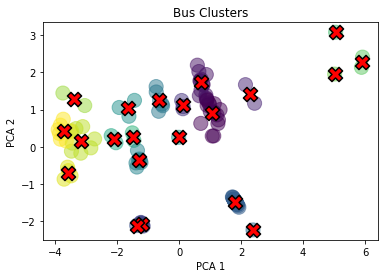

In [128]:
#Final visual representation of clusters
visualizing_results(coord,l,cent)